<a href="https://colab.research.google.com/github/asivak16/asivak16/blob/main/NLP_Pipeline_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas matplotlib seaborn
!pip install stanfordnlp
!pip install gensim
!pip install nltk
!pip install numpy
!pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 2.7 MB/s eta 0:00:00


# New Section

# New Section

In [ ]:
import pandas as pd
from stanfordnlp.server import CoreNLPClient
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
import numpy as np
from gensim.similarities import SoftCosineSimilarity, SparseTermSimilarityMatrix
from gensim.corpora import Dictionary
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def clean_data_corrected(df):
    cols_to_clean = ['Model', 'ADAS/ADS System Version', 'State or Local Permit', 'Operating Entity', 'City', 'State',
                     'Roadway Type', 'Roadway Surface', 'Lighting', 'CP Pre-Crash Movement', 'SV Pre-Crash Movement', 'Narrative']
    for col in cols_to_clean:
        df[col] = df[col].str.strip().str.lower()
    df['Incident Date'] = pd.to_datetime(df['Incident Date'], errors='coerce')
    df[cols_to_clean] = df[cols_to_clean].fillna('unknown')
    df['Model Year'] = pd.to_numeric(df['Model Year'], errors='coerce').fillna(df['Model Year'].median(skipna=True))
    df['Posted Speed Limit (MPH)'] = pd.to_numeric(df['Posted Speed Limit (MPH)'], errors='coerce').fillna(df['Posted Speed Limit (MPH)'].median(skipna=True))
    return df

In [4]:
def process_text_with_corenlp(text, client):
    ann = client.annotate(text)
    return ' '.join([token.word for sentence in ann.sentence for token in sentence.token])

def process_narratives(narratives):
    client = CoreNLPClient(annotators=['tokenize','ssplit','pos','lemma','ner', 'parse', 'depparse'], timeout=30000, memory='16G')
    processed_texts = [process_text_with_corenlp(narrative, client) for narrative in narratives]
    client.stop()
    return processed_texts

In [5]:
def load_glove_model(glove_path):
    return KeyedVectors.load_word2vec_format(glove_path, binary=False)

def narrative_to_vec(narrative, glove_model):
    words = word_tokenize(narrative.lower())
    return np.mean([glove_model[word] for word in words if word in glove_model], axis=0)

def setup_similarity_index(categories, glove_model):
    dictionary = Dictionary([word_tokenize(desc.lower()) for desc in categories.values()])
    corpus = [dictionary.doc2bow(word_tokenize(desc.lower())) for desc in categories.values()]
    similarity_matrix = SparseTermSimilarityMatrix(glove_model, dictionary)
    return SoftCosineSimilarity(corpus, similarity_matrix), dictionary

In [6]:
def categorize_narratives(narrative_vectors, similarity_index, dictionary, categories):
    """
    Categorizes narratives based on their vector representations.
    """
    categorized_results = []
    for narrative_vec in narrative_vectors:
        query_bow = dictionary.doc2bow(word_tokenize(narrative_vec))
        similarities = similarity_index[query_bow]
        categorized_results.append(list(categories.keys())[similarities[0][0]])
    return categorized_results

def mainFunc(file_path):

    data = pd.read_csv(file_path)
  # Define the columns to extract
    columns_to_extract = [
        'Model', 'Model Year', 'ADAS/ADS System Version', 'State or Local Permit', 'Operating Entity',
        'Incident Date', 'City', 'State', 'Roadway Type', 'Roadway Surface', 'Posted Speed Limit (MPH)',
        'Lighting', 'CP Pre-Crash Movement', 'SV Pre-Crash Movement', 'Narrative'
    ]

    # Extract the specific columns from the dataset
    filtered_data = data[columns_to_extract]

    # Replace NaN values in the 'Narrative' column with a placeholder text "unknown"
    filtered_data['Narrative'].fillna("unknown", inplace=True)

    # Categorization dictionary
    categories_dict = {
        "Object/Obstacle avoidance": "crashes object obstacle pedestrians animals stopped vehicles tires",
        "Head-on collision": "crashes head-on vehicles lost control",
        "Head-on collision (wrong way)": "Crashes that take place when a vehicle travels in the wrong-way and hits another vehicle head-on.",
        "Rear-end struck collision": "Crashes that take place when a slow-moving or stopped ego-vehicle is hit by the target vehicle in the back",
        "Off-ramp collision": "Crashes which takes place while the ego vehicle is exiting the highway and entering the off-ramp.",
        "Cut-in maneuver": "Crash caused due to target vehicle making a quick lane change to encroach into the lane of the ego vehicle.",
        "On-ramp collision": "The ego vehicle rear-end strikes the target vehicle stopped or moving ahead of it.",
        "Multi-vehicle interaction": "Complex crashes involving more than 2 vehicles.",
        "Construction zone": "Crashes in which a construction zone was the main cause of the collision.",
        "Ego lane change": "Crashes in which the ego vehicle hits the target vehicle while making a lane change.",
        "Target lane change/Turning": "Crashes where the ego vehicle fails to identify lane change by target vehicle or collides with a turning vehicle.",
        "Other vehicle mistake": "This includes cases when the target vehicle performs unsafe or negligent maneuvers like rolling back, opening the door dangerously, intentional hit and run, unsafe exit from the parking spot, jumping traffic signals, or other kinds of dangerous driving.",
        "Rear-end striking": "The ego vehicle rear-ends the target vehicle stopped or moving ahead of it.",
        "Turning": "Crash caused when the ego vehicle makes an unsafe turn at an intersection.",
        "Software issues": "Crashes caused when the ego vehicle software fails to behave as intended. This failure could be in lane keeping, identifying the edge of a road or road markings, or the computer rebooting/ malfunctioning."
    }

    # Prepare TF-IDF model for categorization
    vectorizer = TfidfVectorizer()
    category_vectors = vectorizer.fit_transform(categories_dict.values())
    narrative_vector = vectorizer.transform(filtered_data['Narrative'])

    # Compute cosine similarity and assign categories
    similarities = cosine_similarity(narrative_vector, category_vectors)
    filtered_data['Category'] = [list(categories_dict.keys())[index] for index in similarities.argmax(axis=1)]

    # Save the new dataset with categories
    new_file_path = '/content/data/Categorized_Incident_Reports.csv'
    filtered_data.to_csv(new_file_path, index=False)

In [7]:
# Function to create different types of plots
def create_visualization(x, y, data, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    if x == 'Category' and y == 'City':
        size = data.groupby([x, y]).size().reset_index(name='Count')
        sns.scatterplot(data=size, x=x, y=y, size='Count', sizes=(20, 200), legend='full')
    elif x == 'Category' and y == 'Lighting':
        count_data = data.groupby(x)[y].value_counts().unstack(fill_value=0)
        count_data.plot(kind='bar', stacked=True)
    elif x == 'Posted Speed Limit (MPH)' and y == 'Roadway Surface':
        pivot_table = data.pivot_table(index=x, columns=y, aggfunc='size', fill_value=0)
        sns.heatmap(pivot_table, cmap='YlGnBu')  # Change the colormap to YlGnBu
    elif x == 'State' and y == 'Category':
        count_data = data.groupby(x)[y].value_counts().unstack(fill_value=0)
        count_data.plot(kind='bar', stacked=True)
    elif x == 'State' and y == 'Operating Entity':
        sns.countplot(data=data, x=x, hue=y, palette='viridis')
    elif x == 'Category' and y == 'Roadway Type':
        sns.countplot(data=data, x=x, hue=y, palette='viridis')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()



<ipython-input-3-ea9a68a314c5>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Incident Date'] = pd.to_datetime(df['Incident Date'], errors='coerce')
<ipython-input-6-4a04599f2927>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Narrative'].fillna("unknown", inplace=True)
<ipython-input-6-4a04599f2927>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Category'] = [list(categories_dict.key

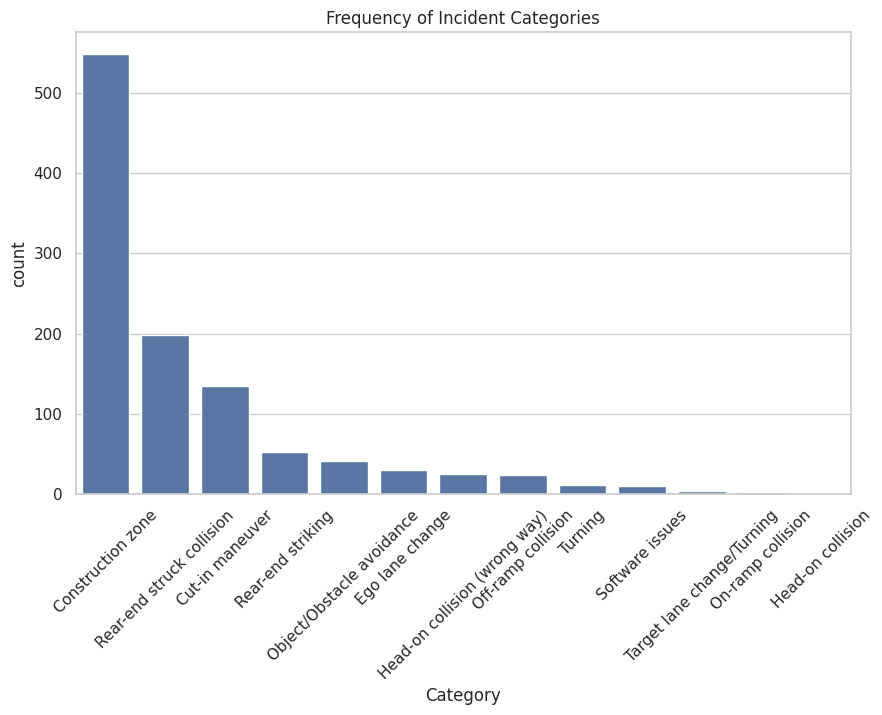

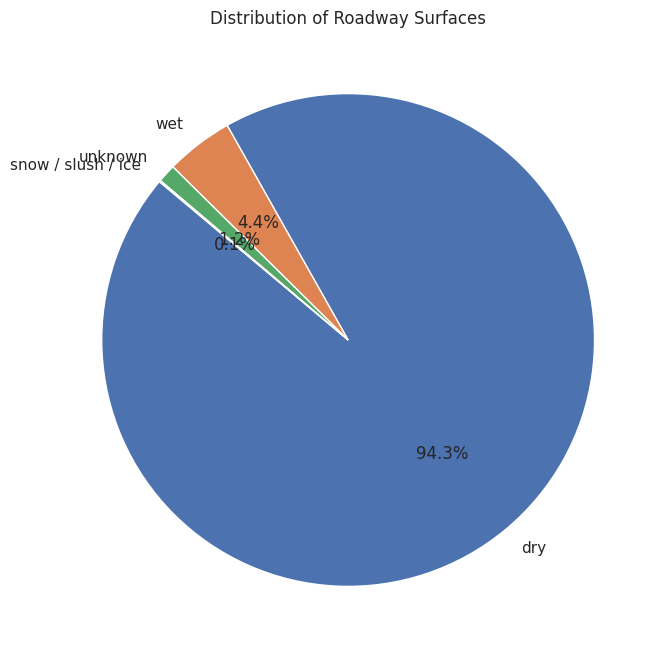

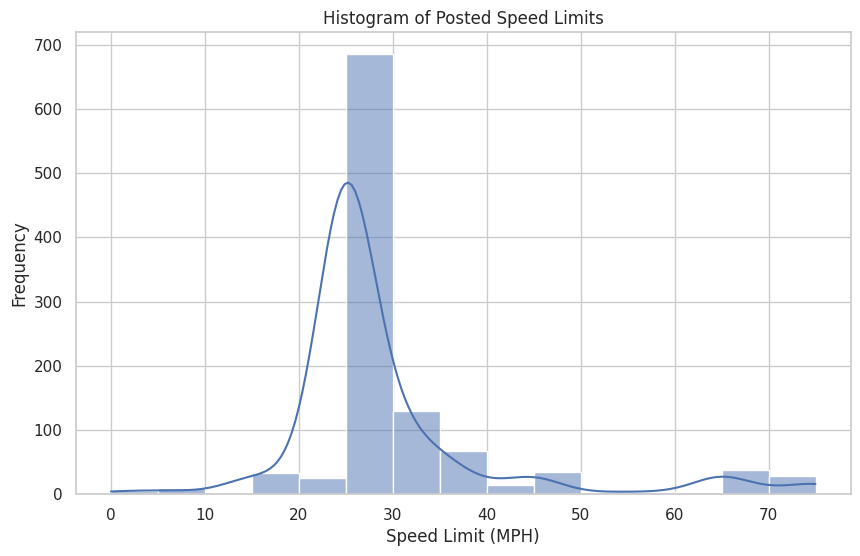

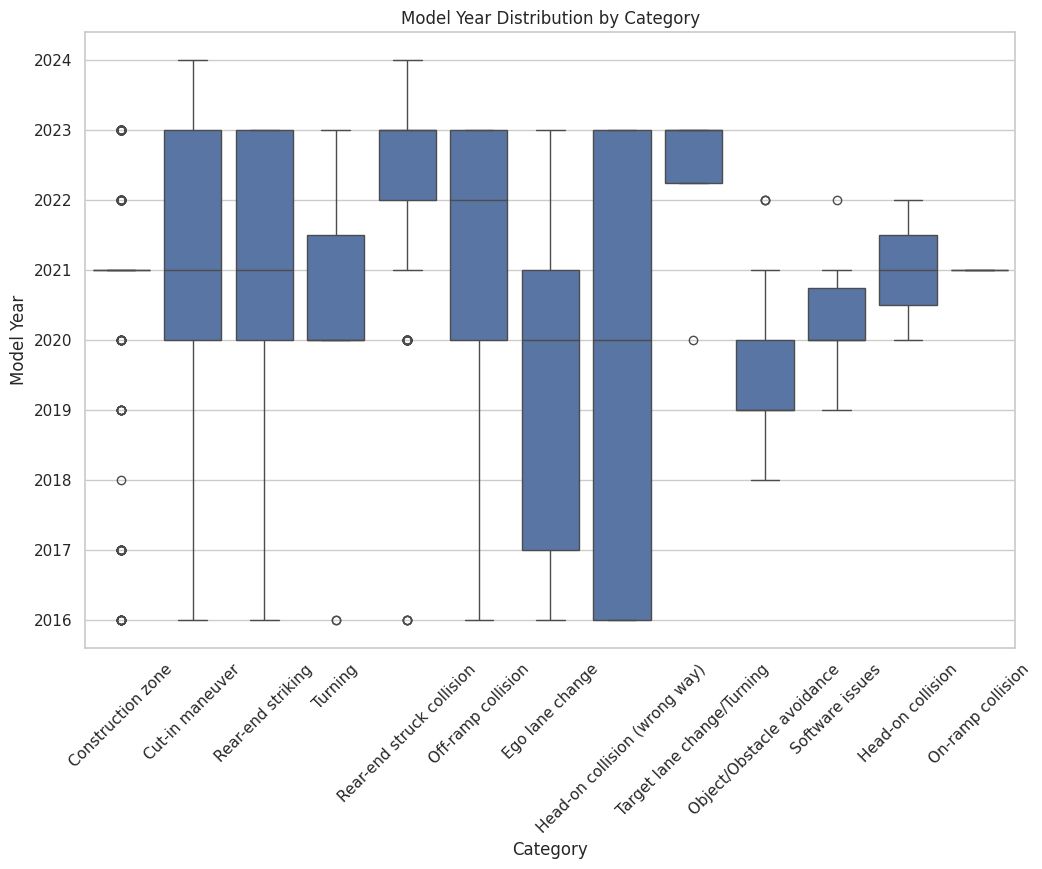

In [11]:
# Load the dataset
file_path = '/content/data/SGO-2021-01_Incident_Reports_ADS.csv'
data = pd.read_csv(file_path)
data.head(), data.columns
# Apply cleaning function to the data
cleaned_data_corrected = clean_data_corrected(data)

# Save the cleaned dataset
cleaned_file_path_corrected = '/content/data/Cleaned_ADS_Incident_Reports_Corrected.csv'
cleaned_data_corrected.to_csv(cleaned_file_path_corrected, index=False)

data = pd.read_csv('Cleaned_ADS_Incident_Reports_Corrected.csv')
narratives = data['Narrative']
#processed_narratives = process_narratives(narratives)

# Load GloVe model and convert narratives to vectors
#glove_model = load_glove_model('path_to_glove_vectors.txt')
#narrative_vectors = [narrative_to_vec(narr, glove_model) for narr in processed_narratives]

# Define categories
categories = {
    "Object/Obstacle avoidance": "crashes object obstacle pedestrians animals stopped vehicles tires",
    "Head-on collision": "crashes head-on vehicles lost control",
"Head-on collision (wrong way)":"Crashes that take place when a vehicle travels in the wrong-way and hits another vehicle head-on.",
"Rear-end struck collision":"Crashes that take place when a slow-moving or stopped ego-vehicle is hit by the target vehicle in the back",
"Off-ramp collision":"Crashes which takes place while the ego vehicle is exiting the highway and entering the off-ramp.",
"Cut-in maneuver":"Crash caused due to target vehicle making a quick lane change to encroach into the lane of the ego vehicle.",
"On-ramp collision":"The ego vehicle rear-end strikes the target vehicle stopped or moving ahead of it.",
"Multi-vehicle interaction":"Complex crashes involving more than 2 vehicles.",
"Construction zone":"Crashes in which a construction zone was the main cause of the collision.",
"Ego lane change":"Crashes in which the ego vehicle hits the target vehicle while making a lane change.",
"Target lane change/Turning":"Crashes where the ego vehicle fails to identify lane change by target vehicle or collides with a turning vehicle.",
"Other vehicle mistake":"This includes cases when the target vehicle performs unsafe or negligent maneuvers like rolling back,opening the door dangerously, intentional hit and run, unsafe exit from the parking spot, jumpingtraffic signals, or other kinds of dangerous driving.",
"Rear-end striking":"The ego vehicle rear-ends the target vehicle stopped or moving ahead of it.",
"Turning":"Crash caused when the ego vehicle makes an unsafe turn at an intersection.",
"Software issues":"Crashes caused when the ego vehicle software fails to behave as intended. This failure could be in lane keeping, identifying the edge of a road or road markings, or the computer rebooting/ malfunctioning.",
    # Add all categories similarly
}

# Save the categorized data
data.to_csv('path_to_categorized_dataset.csv', index=False)

Mfile_path = '/content/data/Cleaned_ADS_Incident_Reports_Corrected.csv'
MainCsv = mainFunc(Mfile_path)


# Load the dataset
data = pd.read_csv('/content/data/Categorized_Incident_Reports.csv')

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Visualization 1: Bar Chart of Incident Categories
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Category', order=data['Category'].value_counts().index)
plt.title('Frequency of Incident Categories')
plt.xticks(rotation=45)
plt.show()

# Visualization 2: Pie Chart of Roadway Surfaces
roadway_counts = data['Roadway Surface'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(roadway_counts, labels=roadway_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Roadway Surfaces')
plt.show()

# Visualization 3: Histogram of Speed Limits
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Posted Speed Limit (MPH)', bins=15, kde=True)
plt.title('Histogram of Posted Speed Limits')
plt.xlabel('Speed Limit (MPH)')
plt.ylabel('Frequency')
plt.show()

# Visualization 4: Boxplot of Model Year by Category
plt.figure(figsize=(12, 8))
sns.boxplot(data=data, x='Category', y='Model Year')
plt.title('Model Year Distribution by Category')
plt.xticks(rotation=45)
plt.show()



In [12]:
# Required installations for the updated version
!pip install pandas stanfordnlp gensim nltk numpy plotly

import pandas as pd
from stanfordnlp.server import CoreNLPClient
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
import numpy as np
from gensim.similarities import SoftCosineSimilarity, SparseTermSimilarityMatrix
from gensim.corpora import Dictionary
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
import plotly.graph_objects as go


# Function to clean the dataset
def clean_data_corrected(df):
    cols_to_clean = ['Model', 'ADAS/ADS System Version', 'State or Local Permit', 'Operating Entity', 'City', 'State',
                     'Roadway Type', 'Roadway Surface', 'Lighting', 'CP Pre-Crash Movement', 'SV Pre-Crash Movement', 'Narrative']
    for col in cols_to_clean:
        df[col] = df[col].str.strip().str.lower()
    df['Incident Date'] = pd.to_datetime(df['Incident Date'], errors='coerce')
    df[cols_to_clean] = df[cols_to_clean].fillna('unknown')
    df['Model Year'] = pd.to_numeric(df['Model Year'], errors='coerce').fillna(df['Model Year'].median(skipna=True))
    df['Posted Speed Limit (MPH)'] = pd.to_numeric(df['Posted Speed Limit (MPH)'], errors='coerce').fillna(df['Posted Speed Limit (MPH)'].median(skipna=True))
    return df


# Function to create Plotly visualizations
def create_visualization_plotly(x, y, data, title, xlabel, ylabel):
    if x == 'Category' and y == 'City':
        # Scatter plot with bubble sizes
        size = data.groupby([x, y]).size().reset_index(name='Count')
        fig = px.scatter(size, x=x, y=y, size='Count', title=title)
        fig.update_layout(xaxis_title=xlabel, yaxis_title=ylabel)
    elif x == 'Category' and y == 'Lighting':
        # Stacked bar plot
        count_data = data.groupby(x)[y].value_counts().unstack(fill_value=0)
        fig = px.bar(count_data, barmode='stack', title=title)
        fig.update_layout(xaxis_title=xlabel, yaxis_title=ylabel)
    elif x == 'Posted Speed Limit (MPH)' and y == 'Roadway Surface':
        # Heatmap
        pivot_table = data.pivot_table(index=x, columns=y, aggfunc='size', fill_value=0)
        fig = go.Figure(data=go.Heatmap(
            z=pivot_table.values,
            x=pivot_table.columns,
            y=pivot_table.index,
            colorscale='YlGnBu'
        ))
        fig.update_layout(title=title, xaxis_title=xlabel, yaxis_title=ylabel)
    elif x == 'State' and y == 'Category':
        # Stacked bar plot by state
        count_data = data.groupby(x)[y].value_counts().unstack(fill_value=0)
        fig = px.bar(count_data, barmode='stack', title=title)
        fig.update_layout(xaxis_title=xlabel, yaxis_title=ylabel)
    elif x == 'State' and y == 'Operating Entity':
        # Grouped bar plot by operating entity
        fig = px.histogram(data, x=x, color=y, title=title)
        fig.update_layout(xaxis_title=xlabel, yaxis_title=ylabel)
    elif x == 'Category' and y == 'Roadway Type':
        # Count plot for roadway type by category
        fig = px.histogram(data, x=x, color=y, title=title)
        fig.update_layout(xaxis_title=xlabel, yaxis_title=ylabel)

    fig.show()

# Main function for loading data and categorizing narratives (as per original code)
def mainFunc(file_path):
    data = pd.read_csv(file_path)
    columns_to_extract = [
        'Model', 'Model Year', 'ADAS/ADS System Version', 'State or Local Permit', 'Operating Entity',
        'Incident Date', 'City', 'State', 'Roadway Type', 'Roadway Surface', 'Posted Speed Limit (MPH)',
        'Lighting', 'CP Pre-Crash Movement', 'SV Pre-Crash Movement', 'Narrative'
    ]
    filtered_data = data[columns_to_extract]
    filtered_data['Narrative'].fillna("unknown", inplace=True)

    # Categorization logic here as per original code

    new_file_path = '/content/data/Categorized_Incident_Reports.csv'
    filtered_data.to_csv(new_file_path, index=False)


# Example usage of create_visualization_plotly
data = pd.read_csv('/content/data/Categorized_Incident_Reports.csv')

# Visualization 1: Bar Chart of Incident Categories using Plotly
fig = px.bar(data, x='Category', title='Frequency of Incident Categories')
fig.update_layout(xaxis_title='Category', yaxis_title='Count', xaxis={'categoryorder': 'total descending'})
fig.show()

# Visualization 2: Pie Chart of Roadway Surfaces using Plotly
roadway_counts = data['Roadway Surface'].value_counts()
fig = px.pie(values=roadway_counts, names=roadway_counts.index, title='Distribution of Roadway Surfaces')
fig.show()

# Visualization 3: Histogram of Speed Limits using Plotly
fig = px.histogram(data, x='Posted Speed Limit (MPH)', nbins=15, title='Histogram of Posted Speed Limits')
fig.update_layout(xaxis_title='Speed Limit (MPH)', yaxis_title='Frequency')
fig.show()

# Visualization 4: Boxplot of Model Year by Category using Plotly
fig = px.box(data, x='Category', y='Model Year', title='Model Year Distribution by Category')
fig.update_layout(xaxis_title='Category', yaxis_title='Model Year')
fig.show()

